In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from pathlib import Path
from dotmap import DotMap
import aeon.io.api as aeon
import matplotlib.pyplot as plt
from aeon.schema.streams import Device
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled
from aeon.io.reader import Chunk, Csv, Harp
from aeon.schema import ephys

In [2]:
ephys_root = Path('/ceph/aeon/aeon/data/raw/AEONX1/social-ephys0.1/')
root = '/ceph/aeon/aeon/data/raw/AEON2/social-ephys0.1/'
behavior_epoch = '2024-06-04T10-29-49'
ephys_epoch = '2024-06-04T10-24-07'

In [3]:
social_ephys = DotMap(
    [
        Device("NeuropixelsV2Beta", ephys.NeuropixelsV2Beta, ephys.Bno055)
    ])

In [4]:
social_ephys.NeuropixelsV2Beta

DotMap(HarpSync=<aeon.schema.ephys.HarpSync.Reader object at 0x7f2773f47d90>, HarpSyncModel=<aeon.schema.ephys.HarpSyncModel.Reader object at 0x7f2773eca890>, Bno055Clock=<aeon.io.reader.Binary object at 0x7f28e854ae10>, _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [12]:
from datetime import datetime
datetime.strptime('2024-06-06T06-00-00.csv', '%Y-%m-%dT%H-%M-%S.csv')

datetime.datetime(2024, 6, 6, 6, 0)

In [5]:
harp_sync = aeon.load(ephys_root, social_ephys.NeuropixelsV2Beta.HarpSync, epoch=ephys_epoch)
harp_sync = harp_sync.iloc[:-2].dropna()

In [4]:
sync_model = aeon.load(ephys_root, social_ephys.NeuropixelsV2Beta.HarpSyncModel, epoch=ephys_epoch)
sync_model

,clock_start,clock_end,model,r2
time,,,,
2024-06-04 10:00:00,291416781,535262419234,LinearRegression(),1.0
2024-06-04 11:00:00,535511939105,1433534571422,LinearRegression(),1.0
2024-06-04 12:00:00,1433784091589,2331806599530,LinearRegression(),1.0
2024-06-04 13:00:00,2332056119822,3230079039651,LinearRegression(),1.0
2024-06-04 14:00:00,3230328559868,4128351623502,LinearRegression(),1.0
...,...,...,...,...
2024-06-10 11:00:00,129886755790227,130784779050922,LinearRegression(),1.0
2024-06-10 12:00:00,130785028571545,131683051723638,LinearRegression(),1.0
2024-06-10 13:00:00,131683301243628,132581324663296,LinearRegression(),1.0


<Axes: ylabel='Frequency'>

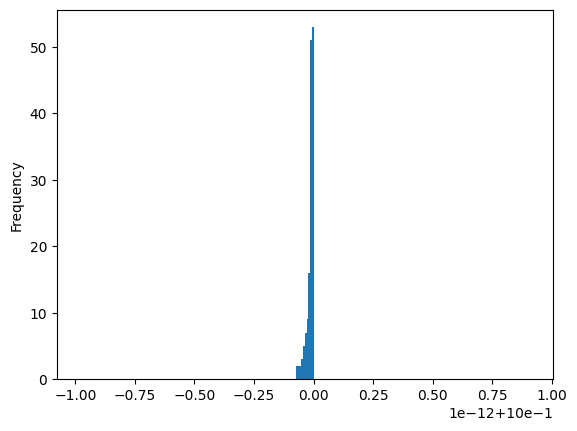

In [14]:
sync_model.r2.reset_index().r2.plot(kind='hist')

<Axes: xlabel='time'>

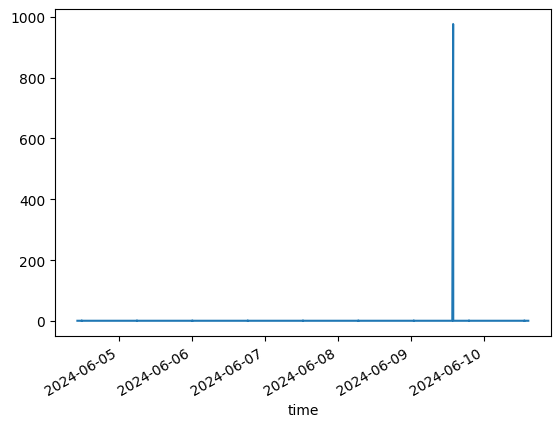

In [24]:
harp_sync.dropna().diff()

In [46]:
outlier = harp_sync.clock.diff().argmax()
harp_sync.iloc[outlier-1:outlier+1]

,clock,hub_clock,harp_time
time,,,
2024-06-09 13:43:44,110779507510624,110779507510599,3.800785e+09
2024-06-09 14:00:00,111023039042906,111023039042881,3.800786e+09


In [43]:
harp_sync[harp_sync.clock.diff() > 10e10]

,clock,hub_clock,harp_time
time,,,
2024-06-09 14:00:00,111023039042906,111023039042881,3.800786e+09


In [28]:
from sklearn.linear_model import LinearRegression

onix_clock = harp_sync.clock.values.reshape(-1, 1)
harp_time = harp_sync.harp_time.values.reshape(-1, 1)

model = LinearRegression().fit(onix_clock, harp_time)
r2 = model.score(onix_clock, harp_time)

In [74]:
model_range = slice(0, 20000)
model_v1 = LinearRegression().fit(onix_clock[model_range], harp_time[model_range])
r2_v1 = model_v1.score(onix_clock[model_range], harp_time[model_range])

In [76]:
predicted_time = model_v1.predict(onix_clock[model_range])
predicted_time - harp_time[model_range]

array([[0.00089264],
       [0.00089216],
       [0.00089359],
       ...,
       [0.00088787],
       [0.00088882],
       [0.0008893 ]])

In [73]:
predicted_time - harp_time[model_range]

array([[-1.23977661e-05],
       [-1.23977661e-05],
       [-1.23977661e-05],
       ...,
       [-6.86645508e-05],
       [-6.81877136e-05],
       [-6.77108765e-05]])

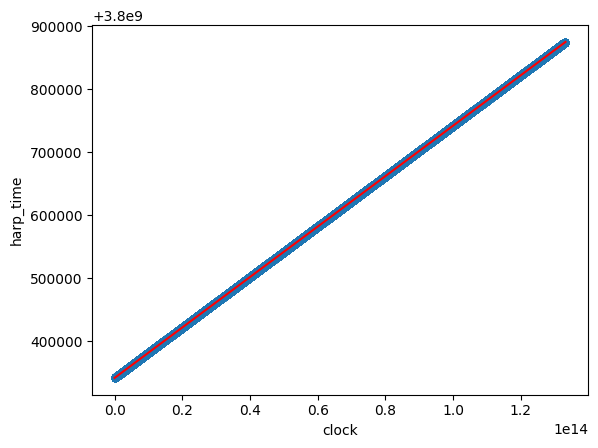

In [33]:
fig, ax = plt.subplots(1, 1)
harp_sync.plot(ax=ax,x='clock', y='harp_time', kind='scatter')
ax.plot(harp_sync.clock, model.predict(onix_clock), 'r')

In [7]:
social_ephys.NeuropixelsV2Beta.Bno055.Clock

DotMap(_ipython_display_=DotMap(), _repr_mimebundle_=DotMap(), _repr_html_=DotMap(), _repr_markdown_=DotMap(), _repr_svg_=DotMap(), _repr_png_=DotMap(), _repr_pdf_=DotMap(), _repr_jpeg_=DotMap(), _repr_latex_=DotMap(), _repr_json_=DotMap(), _repr_javascript_=DotMap())

In [5]:
aeon.load(ephys_root, social_ephys.NeuropixelsV2Beta.Bno055.Clock, epoch=ephys_epoch)

,_typ,dtype,ndim
time,,,
